
## MERFISH data preprocessing

We apply uniPort to integrate high-plex RNA imaging-based spatially resolved MERFISH data with scRNA-seq data. The MERFISH data includes 64,373 cells with 155 genes, and the scRNA-seq data includes 30,370 cells with 21,030 genes from six mice measured with dissociated scRNA-seq (10X).

In [1]:
import uniport as up
import scanpy as sc
import pandas as pd
import numpy as np

Read the cell type annotations of MERFISH and scRNA-seq data seperately.

In [2]:
labels_merfish = pd.read_csv('MERFISH/MERFISH_mouse1_cluster.txt', sep='\t')
celltype_merfish = labels_merfish['cluster_main'].values
labels_rna = pd.read_csv('MERFISH/scRNA_cluster.txt', sep='\t')
celltype_rna = labels_rna['cluster_main'].values

Read MERFISH and scRNA-seq into `AnnData` objects using `load_file` fucntion in uniport.   

In [3]:
adata_merfish = sc.read_h5ad('MERFISH/merfish0.h5ad')
adata_rna = sc.read_h5ad('MERFISH/rna0.h5ad')
# adata_merfish = up.load_file('MERFISH/MERFISH_mouse1.txt')
# adata_rna = up.load_file('MERFISH/RNA_count.txt')

Add 'cell_type', 'domain_id' and 'source' to the `AnnData`objects.\
'cell_type' stores cell label annotations. \
'domain_id' identifies the modality using a number category. \
'source' identifies the modality using its name.

In [4]:
adata_merfish.obs['cell_type'] = celltype_merfish
adata_merfish.obs['domain_id'] = 0
adata_merfish.obs['domain_id'] = adata_merfish.obs['domain_id'].astype('category')
adata_merfish.obs['source'] = 'MERFISH'

adata_rna.obs['cell_type'] = celltype_rna
adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')
adata_rna.obs['source'] = 'RNA'

Concatenate scATAC-seq and scRNA-seq with common genes using `AnnData.concatenate`.

In [5]:
adata_cm = adata_merfish.concatenate(adata_rna, join='inner', batch_key='domain_id')

Preprocess data using functions `normalize_total`, `log1p` and `highly_variable_genes` in `scanpy` and `batch_scale` in uniport (modified from [SCALEX](https://scalex.readthedocs.io/en/latest/api/index.html#preprocessing))

In [6]:
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, batch_key='domain_id', inplace=False, subset=True)
adata_cm = up.batch_scale(adata_cm)
print(adata_cm)

AnnData object with n_obs × n_vars = 94743 × 153
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'


In [7]:
sc.pp.normalize_total(adata_merfish)
sc.pp.log1p(adata_merfish)
sc.pp.highly_variable_genes(adata_merfish, n_top_genes=2000, inplace=False, subset=True)
adata_merfish = up.batch_scale(adata_merfish)
print(adata_merfish)

AnnData object with n_obs × n_vars = 64373 × 155
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


In [8]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
adata_rna = up.batch_scale(adata_rna)
print(adata_rna)

AnnData object with n_obs × n_vars = 30370 × 2000
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


Save the preprocessed data for integration.

In [9]:
adata_merfish.write('MERFISH/MERFISH.h5ad', compression='gzip')
adata_rna.write('MERFISH/RNA.h5ad', compression='gzip')
adata_cm.write('MERFISH/MERFISH_and_RNA.h5ad', compression='gzip')

Visualize the data using UMAP according to their cell types and sources.

In [10]:
sc.pp.pca(adata_cm)
sc.pp.neighbors(adata_cm)
sc.tl.umap(adata_cm)

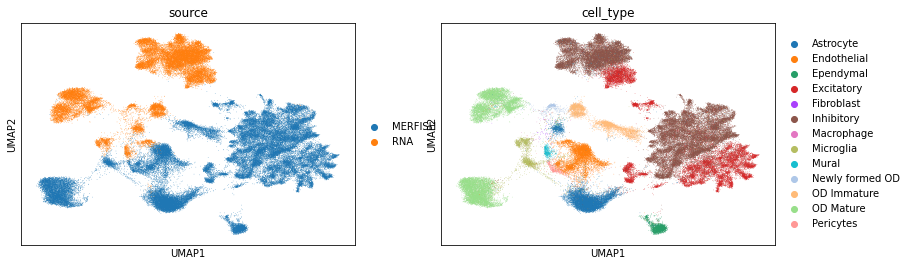

In [11]:
sc.pl.umap(adata_cm, color=['source', 'cell_type'])